In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from pycocotools import mask as mask_util

In [3]:
# Just some plot utils

def bitget(val, idx):
    return (val >> idx) & 1


def pascal_color_map():
    colormap = np.zeros((512, 3), dtype=int)
    ind = np.arange(512, dtype=int)
    for shift in reversed(list(range(8))):
        for channel in range(3):
            colormap[:, channel] |= bitget(ind, channel) << shift
        ind >>= 3

    return colormap.astype(np.uint8)


def draw_masks_to_frame(
    frame: np.ndarray, masks: np.ndarray, colors: np.ndarray
) -> np.ndarray:
    masked_frame = frame
    for mask, color in zip(masks, colors):
        curr_masked_frame = np.where(mask[..., None], color, masked_frame)
        masked_frame = cv2.addWeighted(masked_frame, 0.75, curr_masked_frame, 0.25, 0)

        if int(cv2.__version__[0]) > 3:
            contours, _ = cv2.findContours(
                np.array(mask, dtype=np.uint8).copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
            )
        else:
            _, contours, _ = cv2.findContours(
                np.array(mask, dtype=np.uint8).copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
            )

        cv2.drawContours(masked_frame, contours, -1, color.tolist(), 3)
    return masked_frame


COLORS = pascal_color_map()[1:]

In [6]:
with open("saco_veval_data/09242025/sa_fari_test.json", "r") as f:
    data = json.load(f)

video_df = pd.DataFrame(data["videos"])
annot_df = pd.DataFrame(data["annotations"])
pair_df = pd.DataFrame(data["video_np_pairs"])

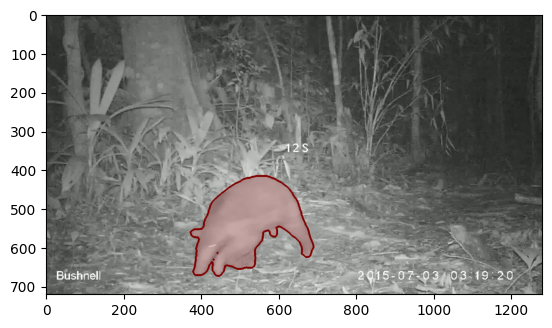

In [11]:
example_masklet = annot_df.iloc[0]

# Read image
jpg_path = f"saco_veval_data/09242025/JPEGImages/sa_fari/{example_masklet.video_id}/00000.jpg"
im = cv2.imread(jpg_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Read RLE
masks = np.array([mask_util.decode(rle) for rle in [example_masklet.segmentations[0]]])
masked_frame = draw_masks_to_frame(
    frame=im, masks=masks, colors=COLORS[: len(masks)]
)

plt.imshow(masked_frame)
